In [1]:
import pandas as pd
import numpy as np
import geopy as geo
import matplotlib.pyplot as plt

In [2]:

i=0
for chunk in  pd.read_csv('train.csv', chunksize=200000, nrows = 2000000, low_memory=False, parse_dates=['pickup_datetime']):
    if i==0:
        df = chunk
        i +=1
        print("Read Chunk ----> ", i)
    else:
        df = pd.concat([df,chunk], axis= 0)
        i +=1
        print("Read Chunk ----> ", i)
   



# data = pd.read_csv("loan.csv", low_memory=False)

# df = pd.read_csv('train2.csv',nrows = 2000000, parse_dates=['pickup_datetime'])

Read Chunk ---->  1
Read Chunk ---->  2
Read Chunk ---->  3
Read Chunk ---->  4
Read Chunk ---->  5
Read Chunk ---->  6
Read Chunk ---->  7
Read Chunk ---->  8
Read Chunk ---->  9
Read Chunk ---->  10


In [3]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


In [4]:
print('Old size: %d' % len(df))
df = df[df.fare_amount>=0]
print('New size: %d' % len(df))

Old size: 2000000
New size: 1999923


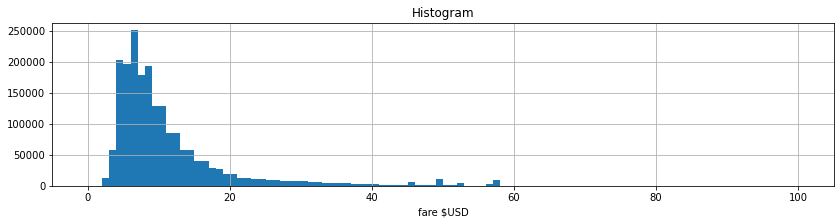

In [5]:
# plot histogram of fare
df[df.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

In [6]:
print(df.isnull().sum())
df = df.dropna()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64


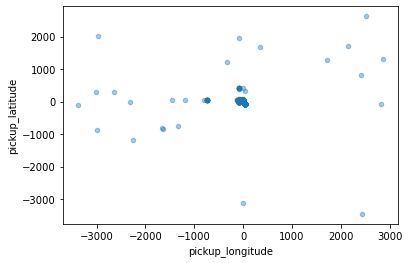

In [7]:
# nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')
df.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", alpha=0.4)
plt.show()

In [8]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')



In [9]:
print('Old size: %d' % len(df))
df2 = df[select_within_boundingbox(df, BB)]
print('New size: %d' % len(df2))

Old size: 1999909
New size: 1957918


In [10]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)


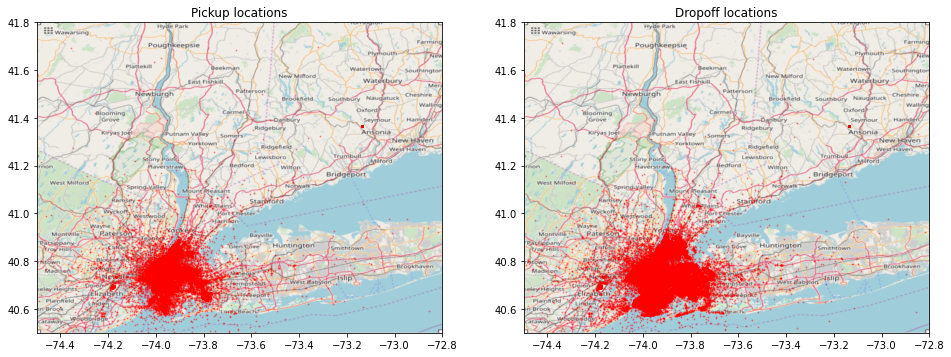

In [11]:
# plot training data on map
plot_on_map(df2, BB, nyc_map, s=1, alpha=0.3)

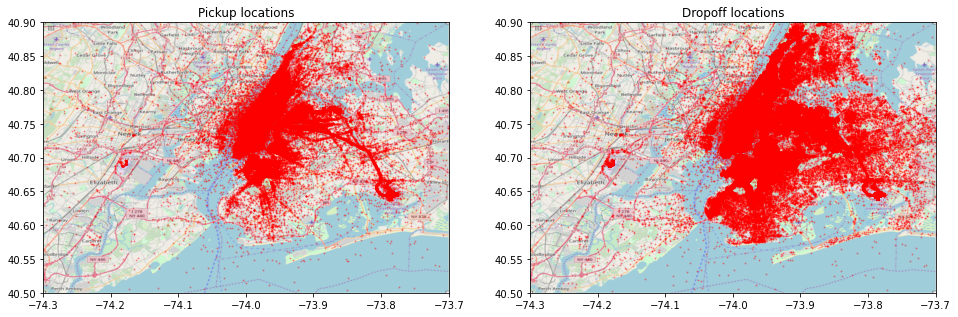

In [12]:
# plot training data on map zoomed in
plot_on_map(df2, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

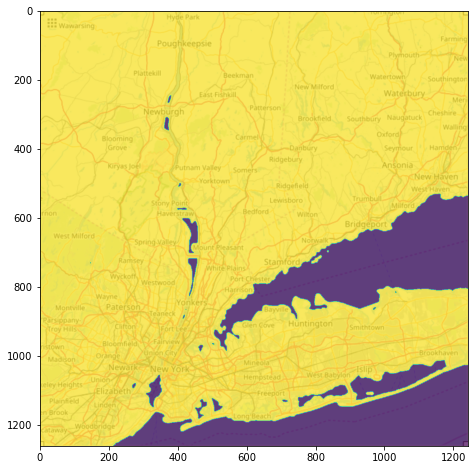

In [13]:
# read nyc mask and turn into boolean map with
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in black, False in white.

In [14]:
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [15]:
pickup_x, pickup_y = lonlat_to_xy(df2.pickup_longitude, df2.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(df2.dropoff_longitude, df2.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [16]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 388


In [17]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [18]:
print('Old size: %d' % len(df2))
df2 = remove_datapoints_from_water(df2)
print('New size: %d' % len(df2))

Old size: 1957918
New size: 1957530


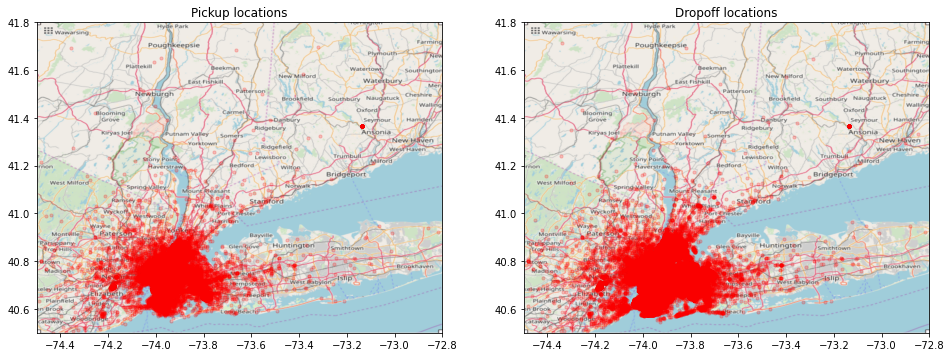

In [19]:
# plot training data
plot_on_map(df2, BB, nyc_map)

In [20]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [21]:
df2['distance_miles'] = distance(df2.pickup_latitude, df2.pickup_longitude, df2.dropoff_latitude, df2.dropoff_longitude)

In [22]:
df2[['passenger_count', 'distance_miles', 'fare_amount']].groupby('passenger_count').mean()

,distance_miles,fare_amount
passenger_count,,
0,1.732107,8.813325
1,2.040013,11.202837
2,2.179313,11.800007
3,2.100634,11.519105
4,2.132165,11.721121
5,2.072168,11.215987
6,2.122414,12.169590
9,8.106351,104.000000


In [23]:
print("Average $USD/Mile : {:0.2f}".format(df2.fare_amount.sum()/df2.distance_miles.sum()))

Average $USD/Mile : 5.48


In [24]:
# remove datapoints with distance <0.05 miles
idx = (df2.distance_miles >= 0.05)
print('Old size: %d' % len(df2))
df2 = df2[idx]
print('New size: %d' % len(df2))

Old size: 1957530
New size: 1926254


In [25]:
df2['fare_per_mile'] = df2.fare_amount / df2.distance_miles
df2.fare_per_mile.describe()

count    1.926254e+06
mean     7.419784e+00
std      1.231459e+01
min      0.000000e+00
25%      4.770449e+00
50%      6.133819e+00
75%      8.085931e+00
max      3.812572e+03
Name: fare_per_mile, dtype: float64

In [26]:
df2['year'] = df2.pickup_datetime.apply(lambda t: t.year)
df2['weekday'] = df2.pickup_datetime.apply(lambda t: t.weekday())
df2['hour'] = df2.pickup_datetime.apply(lambda t: t.hour)

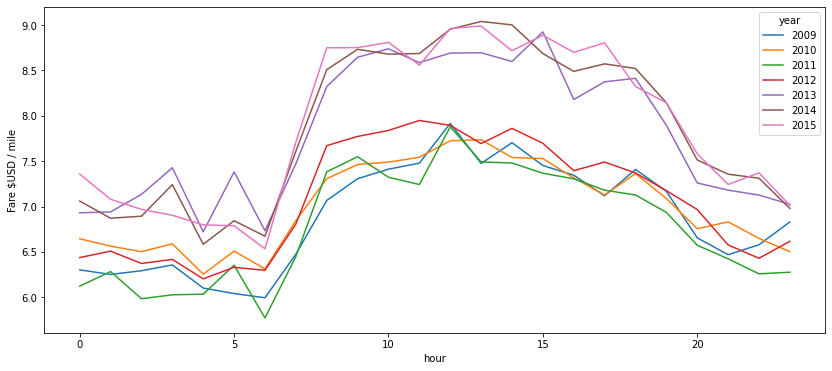

In [27]:
# display pivot table
df2.pivot_table('fare_per_mile', index='hour', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare $USD / mile');

In [28]:
df2['manhatten_distance'] = np.abs(df2['pickup_longitude'] - df2['dropoff_longitude']) + \
np.abs(df2['pickup_latitude'] - df2['dropoff_latitude'])

In [29]:
df2.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_miles,fare_per_mile,year,weekday,hour,manhatten_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,7.025903,2009,0,17,0.011742
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,3.218637,2010,1,16,0.107481
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,6.601723,2011,3,0,0.019212
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,4.426850,2012,5,4,0.029386
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,4.266560,2010,1,7,0.027194


In [30]:
from geopy.geocoders import Nominatim

In [31]:
geolocator = Nominatim(user_agent="myGeocoder")
location = geolocator.reverse("40.63574582350641, -73.82606577222559 ")
location = geolocator.geocode("Allerton")


In [32]:
print((location.latitude, location.longitude))

(39.915319, -87.93321507559128)


In [33]:
# def generate_pickup_location (row):
#     return geolocator.reverse(str(row['pickup_latitude']) + " , "+ str(row['pickup_longitude']))
# def generate_dropoff_location (row):
#     return geolocator.reverse(str(row['dropoff_latitude']) + " , "+ str(row['dropoff_longitude']))

In [34]:
# df['pickup_location'] = df.apply(lambda x: generate_pickup_location(x), axis=1)

In [35]:
# df['dropoff_location'] = df.apply(lambda x: generate_dropoff_location(x), axis=1)

In [36]:

# day = dt.datetime(2009, 12, 2, 6, 30)
# night = dt.datetime(2009, 12, 3, 18, 30)
# late_night = dt.datetime(2009, 12, 3, 22, 30)

def day_time(x):
    x = datetime.time(x.hour, x.minute, x.second)
    if (x >= datetime.time(6,30,00) and x < datetime.time(18,30,00)): return 'day'
    elif (x >= datetime.time(18,30,00) and x < datetime.time(22,30,00)): return 'night'
    else : return 'late_night'


In [37]:
# df['time'] = df['pickup_datetime'].apply(lambda x : day_time(x))

In [38]:
df['distance'] = np.abs(df['pickup_longitude'] - df['dropoff_longitude']) + np.abs(df['pickup_longitude'] - df['dropoff_longitude']) + \
np.abs(df['pickup_latitude'] - df['dropoff_latitude'])

In [39]:
df2.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_miles,fare_per_mile,year,weekday,hour,manhatten_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,7.025903,2009,0,17,0.011742
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,3.218637,2010,1,16,0.107481
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,6.601723,2011,3,0,0.019212
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,4.426850,2012,5,4,0.029386
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,4.266560,2010,1,7,0.027194


In [40]:
df_clean = df2[['fare_amount', 'passenger_count', 'weekday', 'hour', 'distance_miles', 'manhatten_distance', 'year']]
df_clean.head()

,fare_amount,passenger_count,weekday,hour,distance_miles,manhatten_distance,year
0,4.5,1,0,17,0.640487,0.011742,2009
1,16.9,1,1,16,5.250670,0.107481,2010
2,5.7,2,3,0,0.863411,0.019212,2011
3,7.7,1,5,4,1.739386,0.029386,2012
4,5.3,1,1,7,1.242218,0.027194,2010


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ridge_regression
from sklearn.metrics import mean_squared_error as MSE

In [42]:
df_train = df_clean[df_clean['year'] <= 2013].drop('year', axis=1)
df_test = df_clean[df_clean['year'] > 2013].drop('year', axis=1)

In [43]:
# df_encoded = pd.get_dummies(df_clean)

In [44]:
X_train = df_train.drop('fare_amount', axis =1)
X_test = df_test.drop('fare_amount', axis =1)
y_train = df_train['fare_amount']
y_test = df_test['fare_amount']

In [45]:
lr = LinearRegression()

lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

mse_lr = MSE(y_test, lr_predict)

# Compute rmse_lr
rmse_lr = mse_lr**(0.5)

# Print rmse_lr
print('Linear Regression test set RMSE: {:.2f}'.format(rmse_lr))

Linear Regression test set RMSE: 5.51


In [46]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

mse_dt = MSE(y_test, rf_predict)

# Compute rmse_dt
rmse_dt = mse_dt**(0.5)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

MemoryError: could not allocate 117440512 bytes

In [47]:
X_train.head()


,passenger_count,weekday,hour,distance_miles,manhatten_distance
0,1,0,17,0.640487,0.011742
1,1,1,16,5.250670,0.107481
2,2,3,0,0.863411,0.019212
3,1,5,4,1.739386,0.029386
4,1,1,7,1.242218,0.027194


In [ ]:
a = np.array([4, 2,0.22,0,1,0]).reshape(1,-1)

In [ ]:
b = rf.predict(a)

In [ ]:
print(b)